In [14]:
import numpy as np

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as mt

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.transforms.functional as F

import pickle
from PIL import Image

In [15]:
def extractFromPickle(file): # extract data from Pickle file 
    with open(file, 'rb') as fo:
        rawData = pickle.load(fo, encoding='bytes')
    return rawData

In [41]:
train_path = '../train_CIFAR.pickle' # train file
train_data = extractFromPickle(train_path)
test_path = '../test_CIFAR.pickle' # test file
test_data = extractFromPickle(test_path)

In [59]:
CIFAR_X_train = train_data["X"]
CIFAR_Y_train = train_data["Y"]
CIFAR_X_test = test_data["X"]
CIFAR_Y_test = test_data["Y"]

In [43]:
X_train = CIFAR_X_train
X_train = X_train.reshape(10000,3,32,32).transpose(0,2,3,1) # changing dimension
X_test = CIFAR_X_test
X_test = X_test.reshape(2000,3,32,32).transpose(0,2,3,1)
print(X_train.shape,X_test.shape)

(10000, 32, 32, 3) (2000, 32, 32, 3)


In [44]:
alexnet = models.alexnet(pretrained=True) # alexnet--> pretrained model
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [45]:
# transforming the images with standard parameters
apply_transform = transforms.Compose([
    transforms.Resize((227, 4096)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [46]:
# feature extraction --> vector
def getVector(image):
    t_img = Variable(apply_transform(image)).unsqueeze(0)
    output = alexnet.classifier[6](t_img).detach().numpy().ravel()
    return output

In [47]:
# images for train loading
img = []
for i in range(100):
    img.append(Image.fromarray(np.uint8(X_train[i])))

In [48]:
# getting feature vector
featureVector = []
for i in range(len(img)):
    featureVector.append((getVector(img[i])))

featureVector

[array([-3.7891521 , -3.6465735 , -2.502182  , ...,  0.7252683 ,
        -0.92291474, -1.3890216 ], dtype=float32),
 array([-0.83068347,  0.5427722 ,  0.9590305 , ...,  4.3881207 ,
        -5.524552  , -7.214411  ], dtype=float32),
 array([-6.509696  , -6.5835776 , -4.3020487 , ..., -2.3036025 ,
         0.04658264,  4.2700887 ], dtype=float32),
 array([-0.480734  , -0.37604654, -0.26815718, ..., -0.30284867,
         0.47090805,  0.64071554], dtype=float32),
 array([ 4.389064 ,  5.042168 ,  3.6276233, ..., -2.8183482,  4.4528646,
         5.5234685], dtype=float32),
 array([-9.211034 , -9.186909 , -6.1386395, ...,  3.5846238, -5.5228353,
        -6.740527 ], dtype=float32),
 array([-1.3634087, -1.0419294, -0.7115019, ...,  2.4239845, -4.269931 ,
        -5.2790036], dtype=float32),
 array([ 4.4561996,  2.938081 ,  2.3101883, ..., -1.6976565,  5.0333786,
         3.9766316], dtype=float32),
 array([ 4.0550914,  4.2427993,  2.733053 , ...,  0.995495 , -1.1971126,
        -2.1919122], dt

In [50]:
# selecting 10% of test images
testImg = []
for i in range(10):
    testImg.append(Image.fromarray(np.uint8(X_test[i])))

In [51]:
# getting test images feature vector
testFeatures = []
for i in range(len(testImg)):
    testFeatures.append((getVector(testImg[i])))

In [52]:
# PCA--> Principal Component Analysis
pca = PCA(n_components=2)
pcaTrain = pca.fit_transform(featureVector)
pcaTest = pca.fit_transform(testFeatures)

In [66]:
# Training using Linear SVM
model = svm.SVC(kernel ='linear', C=1)

y_train_subset = []
for i in range(100):
    y_train_subset.append(CIFAR_Y_train[i])
    
model.fit(pcaTrain, y_train_subset)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
yPredicted = model.predict(pcaTest) # predicted values

In [69]:
y_test_actual = []
for i in range(10):
    y_test_actual.append(CIFAR_Y_test[i])
accuracy_score(y_test_actual,yPredicted)

0.4

In [70]:
#FP=false positive; TP=true positive; thresholds

FP, TP, thresholds = metrics.roc_curve(y_test_actual, yPredicted, pos_label=2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [71]:
TP = [0]*len(TP)

roc_auc=auc(FP,TP) # roc_curve 

In [72]:
confusion_matrix(y_test_actual, yPredicted) # constructing confusion matrix

array([[2, 4],
       [2, 2]])

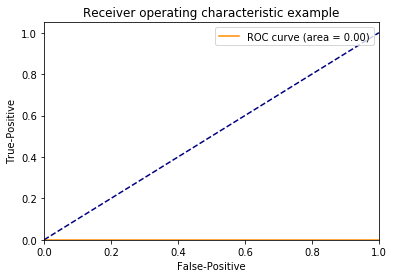

In [73]:
mt.plot(FP, TP, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
mt.plot([0, 1], [0, 1], color='navy', linestyle='--')

mt.xlim([0.0, 1.0])
mt.ylim([0.0, 1.05])
mt.ylabel('True-Positive')
mt.xlabel('False-Positive')

mt.title('Receiver operating characteristic example')
mt.legend(loc="upper right")

mt.show()